In [2]:
import argparse
import os
import sys

from chainer import optimizers
import gym
from gym import spaces
import gym.wrappers
import numpy as np

import chainerrl
from chainerrl.agents.dqn import DQN
from chainerrl import experiments
from chainerrl import explorers
from chainerrl import links
from chainerrl import misc
from chainerrl import q_functions
from chainerrl import replay_buffer

/Users/sykwer/work/i18-sykwer/appv0/venv/lib/python3.7/site-packages/chainer-5.0.0b3-py3.7.egg/chainer/_environment_check.py:38: UserWarning: Accelerate has been detected as a NumPy backend library.
vecLib, which is a part of Accelerate, is known not to work correctly with Chainer.
We recommend using other BLAS libraries such as OpenBLAS.
For details of the issue, please see
https://docs.chainer.org/en/stable/tips.html#mnist-example-does-not-converge-in-cpu-mode-on-mac-os-x.

Also note that Chainer does not officially support Mac OS X.
Please use it at your own risk.

  ''')  # NOQA


In [3]:
outdir = "results"
env_name = "Pendulum-v0"
seed = 0
gpu = -1
final_exploration_steps = 10 ** 4
start_epsilon = 1.0
end_epsilon = 0.1
noisy_net_sigma = None
demo = True
load = None
steps = 10 ** 5
prioritized_replay = False
episodic_replay = False
replay_start_size = 1000
target_update_interval = 10 ** 2
target_update_method = "hard"
soft_update_tau = 1e-2
update_interval = 1
eval_n_runs = 100
eval_interval = 10 ** 4
n_hidden_channels = 100
n_hidden_layers = 2
gamma = 0.99
minibatch_size = None
render_train = False
render_eval = True
monitor = False
reward_scale_factor = 1e-3

In [4]:
misc.set_random_seed(seed)

In [5]:
def clip_action_filter(a):
    return np.clip(a, action_space.low, action_space.high)

def make_env():
    env = gym.make(env_name)
    misc.env_modifiers.make_action_filtered(env, clip_action_filter)
    return env

In [6]:
env = make_env()
timestep_limit = env.spec.tags.get("wrapper_config.TimeLimit.max_episode_steps")
obs_space = env.observation_space
obs_size = obs_space.low.size
action_space = env.action_space
action_size = action_space.low.size

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [7]:
print("obs_space: ", obs_space)
print("obs_size: ", obs_size)
print("action_space: ", action_space)
print("action_size: ", action_size)

obs_space:  Box(3,)
obs_size:  3
action_space:  Box(1,)
action_size:  1


In [8]:
q_func = q_functions.FCQuadraticStateQFunction(
    obs_size, action_size, n_hidden_channels=n_hidden_channels, n_hidden_layers=n_hidden_layers,
    action_space=action_space
)

ou_sigma = (action_space.high - action_space.low) * 0.2
explorer = explorers.AdditiveOU(sigma=ou_sigma)

In [9]:
opt = optimizers.Adam()
opt.setup(q_func)

In [10]:
rbuf_capacity = 5 * 10**5
minibatch_size = 32
rbuf = replay_buffer.ReplayBuffer(rbuf_capacity)

In [11]:
def phi(obs):
    return obs.astype(np.float32)

In [12]:
agent = DQN(q_func, opt, rbuf, gpu=gpu, gamma=gamma, explorer=explorer,
           replay_start_size=replay_start_size, target_update_interval=target_update_interval,
           update_interval=update_interval,
           phi=phi, minibatch_size=minibatch_size, target_update_method=target_update_method,
           soft_update_tau=soft_update_tau, episodic_update=episodic_replay, episodic_update_len=16)

In [13]:
obs = env.reset()
done = False
test_r = 0
t = 0

action_list = []
image_list = []

while not (done or t == timestep_limit):
    image_list.append(env.render(mode="rgb_array"))
    
    a = agent.act(obs)
    action_list.append(a[0])
    obs, r, done, info = env.step(a)
    test_r += r
    t += 1

agent.stop_episode()

In [15]:
import matplotlib.pyplot as plt

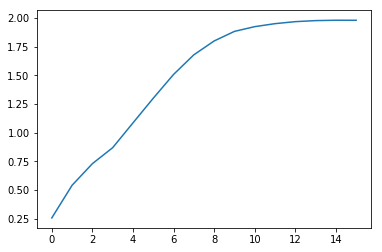

In [25]:
plt.plot(action_list[0:16])
plt.show()

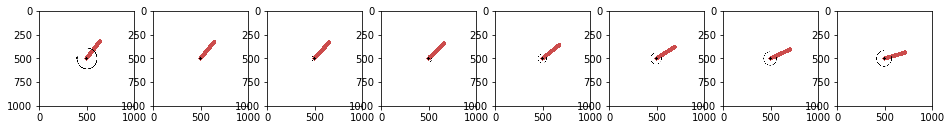

In [27]:
fig = plt.figure(figsize=[16, 2])

for i in range(1, 9):
    ax = fig.add_subplot("18{}".format(i))
    ax.imshow(image_list[i-1])

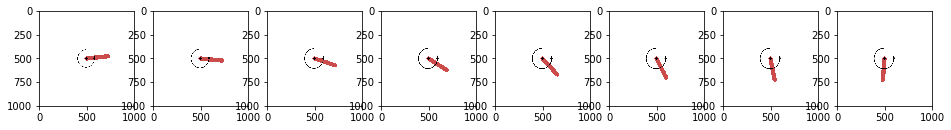

In [28]:
fig = plt.figure(figsize=[16, 2])

for i in range(9, 17):
    ax = fig.add_subplot("18{}".format(i-8))
    ax.imshow(image_list[i-1])

In [33]:
action_value = agent.model(agent.batch_states([obs], agent.xp, agent.phi))

In [36]:
action_value.greedy_actions

variable([[0.61279196]])

In [37]:
action_value.max

variable([0.211856])

In [40]:
action_value.compute_advantage(action_value.greedy_actions)

variable([0.])

In [48]:
agent.average_q

0.06919985128392336